In [1]:
from os import listdir
import os.path as op
from glob import glob
import SpectralEvents.spectralevents_functions as tse
import dill

import numpy as np
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pandas as pd

import mne
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper
from mne.viz import plot_topomap
from mne.report import Report

from alpha_analysis import fit_ssd, ssd_alpha, ssd_spec_ratios

import seaborn as sns
sns.set()


bads = dict(
    DXFTLCJA=[[], ['MRT35-1609', 'MRT15-1609', 'MRP57-1609', 'MRP56-1609',
                   'MRP23-1609', 'MRP22-1609', 'MRO24-1609', 'MLF67-1609',
                   'MLF66-1609', 'MRP34-1609', 'MLT14-1609']],
    BQBBKEBX=[[], ['MRT21-1609', 'MLT31-1609', 'MLT41-1609', 'MLT51-1609',
                   'MLT21-1609', 'MLT16-1609', 'MLT11-1609', 'MLT22-1609',
                   'MLT12-1609', 'MLT32-1609', 'MLT33-1609', 'MLT42-1609',
                   'MLT43-1609', 'MRF14-1609', 'MRT34-1609', 'MRT27-1609']],
    JBGAZIEO=[[], ['MLF25-1609']],
    QGFMDSZY=[['MLP41-1609'], []],
    ZDIAXRUW=[[], []]
)

In [38]:
data_dir = '/home/ntolley/Jones_Lab/biomag_ketamine'
subj_ids = sorted(list({fname[:8] for fname in listdir(data_dir)}))

In [45]:
def analysis(subj_id, count):
    print(count)
    ch_sel_name = 'MLF23-1609'

    # read in both sessions belonging to a single subject
    raw_sessions = list()
    session_fnames = sorted(glob(op.join(data_dir, subj_id + '*')))

    for session_idx, fname in enumerate(session_fnames):
        raw = mne.io.read_raw_ctf(fname, verbose=False)
        raw.load_data()
        # mark bad channels; maintain symmetry of channels across sessions
        if subj_id in bads:
            for bad_sess_idx in range(2):
                for bad_ch in bads[subj_id][bad_sess_idx]:
                    if bad_ch not in raw.info['bads']:
                        raw.info['bads'].append(bad_ch)
        raw.pick_types(meg=True, eeg=False, ref_meg=False)
        raw.filter(l_freq=1., h_freq=50)
        # raw._data = zscore(raw._data, axis=1)
        raw._data -= raw._data.mean()
        raw._data /= raw._data.std()
        raw.resample(sfreq=500)


        raw_sessions.append(raw)

    # concatenate data and compute a single SSD filter that is applied to both
    # sessions
    ch_idx = np.where(np.array(raw.ch_names) == ch_sel_name)[0][0]
    raw_data = np.stack([raw.get_data() for raw in raw_sessions], axis=0)[:,ch_idx,:]
    raw_data = raw_data.reshape(raw_data.shape[0], -1, raw_data.shape[-1])

    df_list = spectral_events_df(raw_data, subj_id)
    df = pd.concat(df_list)

    return df



In [40]:
def spectral_events_df(raw_data, subj_id):
    Fs = 500                            # Sampling rate of time-series
    findMethod = 1                      # Event-finding method (1 allows for maximal overlap while 2 limits overlap in each respective suprathreshold region)
    width = 7

    thrFOM = 6 #Factors of Median threshold (see Shin et al. eLife 2017 for details concerning this value)

    footprintFreq = 8
    footprintTime = 8
    threshold = 0.00
    neighbourhood_size = (footprintFreq,footprintTime)

    # freq_names = ['alpha', 'beta', 'gamma']
    # freq_ranges = [(9, 14), (15, 29), (40, 80)]

    freq_names = ['alpha']
    freq_ranges = [(9, 14)]

    df_list = list()
    for (low, high), freq_name in zip(freq_ranges, freq_names):

        fVec = np.arange(low, high)            # Vector of fequency values over which to calculate TFR
        numTrials, numSamples = raw_data[:,0,:].shape

        # Validate fVec input
        Fn = Fs/2                   # Nyquist frequency
        dt = 1/Fs                   # Sampling time interval
        Fmin = 1/(numSamples*dt)    # Minimum resolvable frequency
        tVec = np.linspace(0, numSamples/Fs, numSamples)

        thisTFR = mne.time_frequency.tfr_array_morlet(raw_data, Fs, fVec)
        thisTFR = np.real(thisTFR).squeeze()

        thisSpecEvents = tse.spectralevents_find(findMethod, thrFOM, tVec, fVec, thisTFR, ['a', 'b'], 
            neighbourhood_size, threshold, Fs)

        df_temp = pd.DataFrame(thisSpecEvents)
        df_temp = df_temp[df_temp['Outlier Event'] == True]

        drop_cols = ['Event Onset Time', 'Event Offset Time', 'Event Duration', 'Trial', 'Outlier Event', 'Peak Time']
        df_mean = df_temp.groupby('Trial').mean().reset_index()
        df_var = df_temp.groupby('Trial').var().reset_index()
        event_counts = df_temp['Trial'].value_counts()
        for col_name in drop_cols:
            _ = df_mean.pop(col_name)
            _ = df_var.pop(col_name)

        df_mean.columns = df_mean.columns + ' Mean'
        df_mean['Trial'] = [0, 1]
        df_var.columns = df_var.columns + ' Var'
        df_var['Trial'] = [0, 1]

        df_temp = pd.merge(df_mean, df_var)
        df_temp.pop('Trial')
        df_temp['Subj'] = [subj_id, subj_id]
        df_temp['Counts'] = [event_counts[0], event_counts[1]]
        df_temp['Band'] = [freq_name, freq_name]

        df_list.append(df_temp)
    return df_list



In [42]:
df_events_list = [analysis(subj_id for count, subj_id in enumerate(subj_ids))]
df_events = pd.concat(df_events_list)

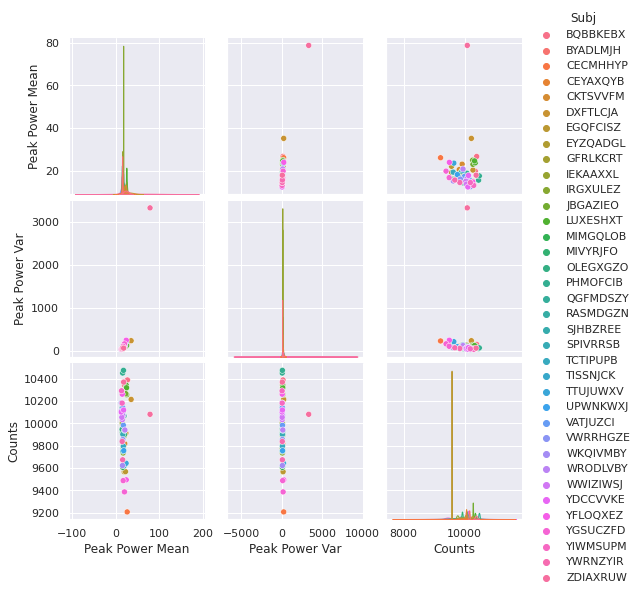

In [12]:
sns.pairplot(df, hue='Subj', vars=['Peak Power Mean', 'Peak Power Var', 'Counts'])

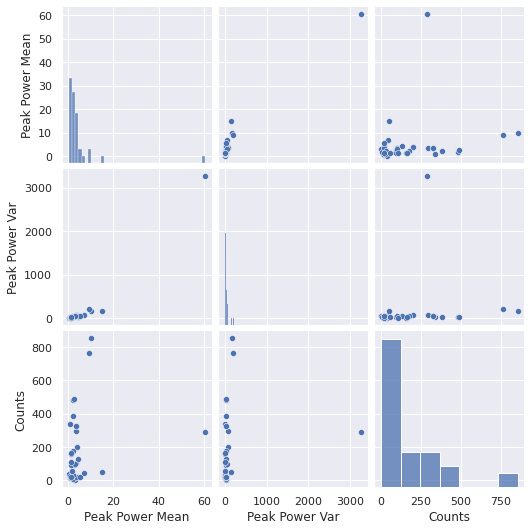

In [13]:
df_diff = df.groupby('Subj').max() - df.groupby('Subj').min()
sns.pairplot(df_diff, vars=['Peak Power Mean', 'Peak Power Var', 'Counts'])


In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_diff.values)

pca = PCA(n_components=10)
pca_data = pca.fit_transform(scaled_data)



Text(0.5, 1.0, 'Alpha Event Diff Feature PCA')

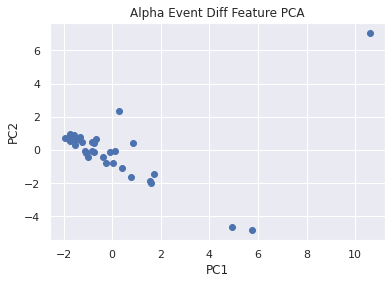

In [15]:
plt.scatter(pca_data[:,0], pca_data[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Alpha Event Diff Feature PCA')

In [34]:
df

,Peak Frequency Mean,Lower Frequency Bound Mean,Upper Frequency Bound Mean,Frequency Span Mean,Peak Power Mean,Normalized Peak Power Mean,Peak Frequency Var,Lower Frequency Bound Var,Upper Frequency Bound Var,Frequency Span Var,Peak Power Var,Normalized Peak Power Var,Subj,Counts
0,7.366667,5.866667,7.466667,1.666667,-16.385672,524.693253,139.067816,143.567816,139.085057,0.643678,192.119180,3.351589e+05,BQBBKEBX,30
1,12.900000,11.700000,12.900000,1.200000,-13.061854,-280.970646,364.100000,368.677778,364.100000,0.177778,199.874822,4.263696e+06,BQBBKEBX,10
0,19.736842,18.736842,19.894737,1.157895,-2.795948,1711.310434,441.982456,441.982456,438.210526,0.473684,16.189996,1.806519e+07,BYADLMJH,19
1,4.160000,2.720000,4.240000,1.600000,-9.811333,347.782731,6.140000,7.376667,6.773333,0.333333,53.815706,9.297928e+05,BYADLMJH,25
0,18.965517,17.758621,18.965517,1.206897,-3.593798,-2079.820704,439.320197,446.189655,439.320197,0.169951,22.735674,1.490357e+07,CECMHHYP,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,6.181818,4.909091,6.181818,1.272727,-6.674853,-109.150793,101.108225,103.134199,101.108225,0.207792,58.838357,1.979152e+05,YIWMSUPM,22
0,13.950000,12.650000,13.950000,1.400000,-3.510377,196.004409,334.681579,341.397368,334.681579,0.568421,15.466049,5.141080e+05,YWRNZYIR,20
1,10.863636,9.545455,10.863636,1.318182,-6.511486,385.618708,243.551948,248.735931,243.551948,0.322511,45.109547,1.469364e+06,YWRNZYIR,22
0,14.833333,13.666667,14.833333,1.166667,-8.130462,-8.094373,433.606061,438.060606,433.606061,0.151515,58.140403,1.413519e+05,ZDIAXRUW,12
